In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,2022-03-21T04:48:46.720Z,38.823833,-122.808000,3.90,0.43,md,14.0,98.00,0.001678,0.0400,...,2022-03-21T20:17:52.874Z,"7km NW of The Geysers, CA",earthquake,0.39,0.28,0.151000,3.0,reviewed,nc,nc
44893,2022-03-21T04:46:01.380Z,38.821835,-122.760834,1.85,0.85,md,7.0,127.00,0.011170,0.0100,...,2022-03-21T05:29:21.342Z,"3km W of Cobb, CA",earthquake,0.48,0.96,NaN,1.0,automatic,nc,nc
44894,2022-03-21T04:41:58.710Z,19.870000,-155.577000,20.18,1.63,md,24.0,120.00,NaN,0.1500,...,2022-03-22T00:38:03.450Z,"19 km SSE of Waimea, Hawaii",earthquake,0.46,0.99,0.124445,15.0,reviewed,hv,hv
44895,2022-03-21T04:39:20.420Z,38.801666,-122.815498,3.22,0.35,md,7.0,161.00,0.012880,0.0100,...,2022-03-21T04:56:14.173Z,"6km WNW of The Geysers, CA",earthquake,0.59,1.06,NaN,1.0,automatic,nc,nc


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,2022-03-21 04:48:46.720000+00:00,38.823833,-122.808000,3.90,0.43,md,14.0,98.00,0.001678,0.0400,...,2022-03-21T20:17:52.874Z,"7km NW of The Geysers, CA",earthquake,0.39,0.28,0.151000,3.0,reviewed,nc,nc
44893,2022-03-21 04:46:01.380000+00:00,38.821835,-122.760834,1.85,0.85,md,7.0,127.00,0.011170,0.0100,...,2022-03-21T05:29:21.342Z,"3km W of Cobb, CA",earthquake,0.48,0.96,NaN,1.0,automatic,nc,nc
44894,2022-03-21 04:41:58.710000+00:00,19.870000,-155.577000,20.18,1.63,md,24.0,120.00,NaN,0.1500,...,2022-03-22T00:38:03.450Z,"19 km SSE of Waimea, Hawaii",earthquake,0.46,0.99,0.124445,15.0,reviewed,hv,hv
44895,2022-03-21 04:39:20.420000+00:00,38.801666,-122.815498,3.22,0.35,md,7.0,161.00,0.012880,0.0100,...,2022-03-21T04:56:14.173Z,"6km WNW of The Geysers, CA",earthquake,0.59,1.06,NaN,1.0,automatic,nc,nc


In [5]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [6]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [7]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.107500,1.10,1.30,1.641433e+09
1,38.181000,-117.818000,7.30,1.40,1.641433e+09
2,61.340700,-149.885200,30.00,1.50,1.641432e+09
3,62.870300,-150.762500,111.30,2.10,1.641432e+09
4,64.014500,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
44892,38.823833,-122.808000,3.90,0.43,1.647838e+09
44893,38.821835,-122.760834,1.85,0.85,1.647838e+09
44894,19.870000,-155.577000,20.18,1.63,1.647838e+09
44895,38.801666,-122.815498,3.22,0.35,1.647838e+09


In [8]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [9]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [10]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [11]:
#establish features to be used in model. X will use: longitude, depth, mag and unix time. Y will be latitude
X = cleaned_df_dropped.drop(['latitude'], axis = 1)

y = cleaned_df_dropped[['latitude']]

In [12]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((44891, 4), (44891, 1))

In [13]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [14]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 68.76815831214373, 	R2 score: 0.836008784396498, 	Model score: 0.836008784396498
n_estimators=3:
	Mean Squared Error: 59.86762338816568, 	R2 score: 0.8572338626526191, 	Model score: 0.8572338626526191
n_estimators=4:
	Mean Squared Error: 55.95324059111555, 	R2 score: 0.8665684792685237, 	Model score: 0.8665684792685237
n_estimators=5:
	Mean Squared Error: 53.62930984790346, 	R2 score: 0.8721103497637002, 	Model score: 0.8721103497637002
n_estimators=6:
	Mean Squared Error: 51.415635964382595, 	R2 score: 0.8773892910647094, 	Model score: 0.8773892910647094
n_estimators=7:
	Mean Squared Error: 50.58670310029177, 	R2 score: 0.8793660447159983, 	Model score: 0.8793660447159983
n_estimators=8:
	Mean Squared Error: 50.573968218999525, 	R2 score: 0.8793964135482448, 	Model score: 0.8793964135482448
n_estimators=9:
	Mean Squared Error: 49.61561182706732, 	R2 score: 0.8816818030882843, 	Model score: 0.8816818030882843
n_estimators=10:
	Mean Squared Error: 49

In [15]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 68.76815831214373, 	R2: 0.836008784396498, 	Model score: 0.836008784396498
n_estimators=3:
	Mean Squared Error: 59.86762338816568, 	R2: 0.8572338626526191, 	Model score: 0.8572338626526191
n_estimators=4:
	Mean Squared Error: 55.95324059111555, 	R2: 0.8665684792685237, 	Model score: 0.8665684792685237
n_estimators=5:
	Mean Squared Error: 53.62930984790346, 	R2: 0.8721103497637002, 	Model score: 0.8721103497637002
n_estimators=6:
	Mean Squared Error: 51.415635964382595, 	R2: 0.8773892910647094, 	Model score: 0.8773892910647094
n_estimators=7:
	Mean Squared Error: 50.58670310029177, 	R2: 0.8793660447159983, 	Model score: 0.8793660447159983
n_estimators=8:
	Mean Squared Error: 50.573968218999525, 	R2: 0.8793964135482448, 	Model score: 0.8793964135482448
n_estimators=9:
	Mean Squared Error: 49.61561182706732, 	R2: 0.8816818030882843, 	Model score: 0.8816818030882843
n_estimators=10:
	Mean Squared Error: 49.7451241458309, 	R2: 0.8813729554600948, 	Model 

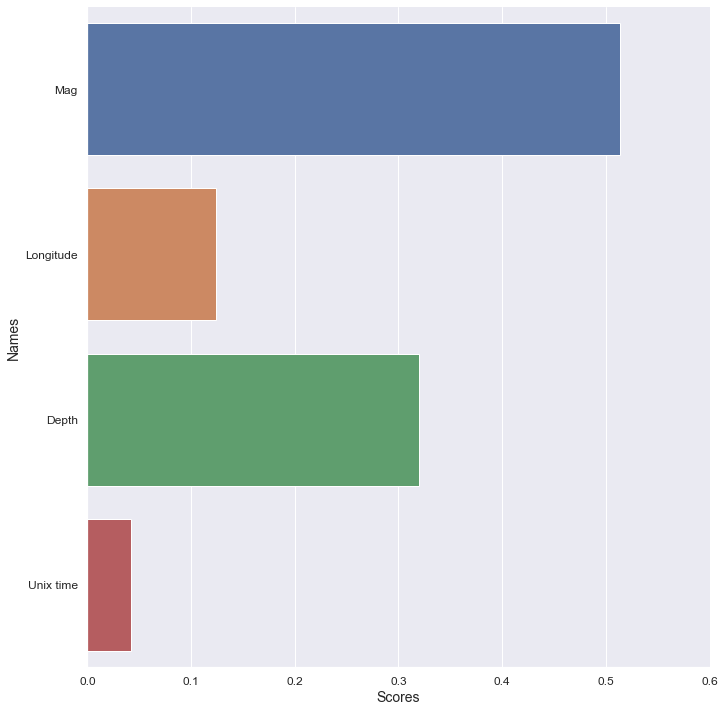

In [16]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['mag', 'longitude', 'depth', 'Unix Time']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [17]:
#define number of splits for cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 4490  4491  4492 ... 44888 44889 44890] | test: [   0    1    2 ... 4487 4488 4489]
Train: [    0     1     2 ... 44888 44889 44890] | test: [4490 4491 4492 ... 8976 8977 8978]
Train: [    0     1     2 ... 44888 44889 44890] | test: [ 8979  8980  8981 ... 13465 13466 13467]
Train: [    0     1     2 ... 44888 44889 44890] | test: [13468 13469 13470 ... 17954 17955 17956]
Train: [    0     1     2 ... 44888 44889 44890] | test: [17957 17958 17959 ... 22443 22444 22445]
Train: [    0     1     2 ... 44888 44889 44890] | test: [22446 22447 22448 ... 26932 26933 26934]
Train: [    0     1     2 ... 44888 44889 44890] | test: [26935 26936 26937 ... 31421 31422 31423]
Train: [    0     1     2 ... 44888 44889 44890] | test: [31424 31425 31426 ... 35910 35911 35912]
Train: [    0     1     2 ... 44888 44889 44890] | test: [35913 35914 35915 ... 40399 40400 40401]
Train: [    0     1     2 ... 40399 40400 40401] | test: [40402 40403 40404 ... 44888 44889 44890]


In [18]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-1.9744212  -2.89578572 -2.35839826 -2.08205738 -2.05554902 -2.17036789
 -2.08760418 -1.96986044 -1.90803505 -1.87665917]
MAE: -2.138 (0.285)


In [19]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [20]:
#create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

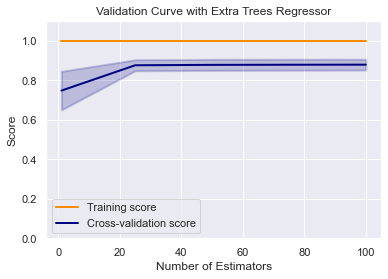

In [21]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [22]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lat = y_test
lats = actual_lat['latitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lats, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 6.557
MAE: 1.857


In [23]:
#make dataframe with actual test values and ML predicted ones
lat_pred = actual_lat
lat_pred['Predicted'] = testpredict


In [24]:
lat_pred = lat_pred.rename(columns={'latitude': 'Actual'})

In [25]:
lat_pred.head(5)

,Actual,Predicted
20932,23.440600,26.735200
2503,37.490333,37.876808
6320,46.887833,45.851841
4336,58.202900,63.711223
4139,33.998333,33.656672


In [26]:
#join dataframes for actual and predicted with original dataframe
lat_pred_all = lat_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lat_pred_all.head(5)

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
20932,23.440600,26.735200,2022-02-13 15:00:15.296000+00:00,23.440600,126.210700,10.00,4.10,mb,NaN,142.0,...,"176 km SSE of Hirara, Japan",earthquake,11.40,2.00,0.303,3.0,reviewed,us,us,1.644764e+09
2503,37.490333,37.876808,2021-12-26 16:40:12.940000+00:00,37.490333,-119.381667,8.46,1.86,md,16.0,84.0,...,"30km NE of Oakhurst, CA",earthquake,0.53,2.42,0.245,14.0,reviewed,nc,nc,1.640537e+09
6320,46.887833,45.851841,2021-12-14 07:48:24.150000+00:00,46.887833,-112.521833,11.66,1.05,ml,9.0,114.0,...,"14 km ESE of Lincoln, Montana",earthquake,0.61,0.78,0.058,3.0,reviewed,mb,mb,1.639468e+09
4336,58.202900,63.711223,2021-12-20 15:49:33.630000+00:00,58.202900,-151.932500,10.30,1.70,ml,NaN,NaN,...,"45 km NE of Ouzinkie, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak,1.640015e+09
4139,33.998333,33.656672,2021-12-21 00:26:38.010000+00:00,33.998333,-116.837833,11.38,0.75,ml,18.0,74.0,...,"9km NNE of Banning, CA",earthquake,0.22,0.49,0.155,6.0,reviewed,ci,ci,1.640046e+09


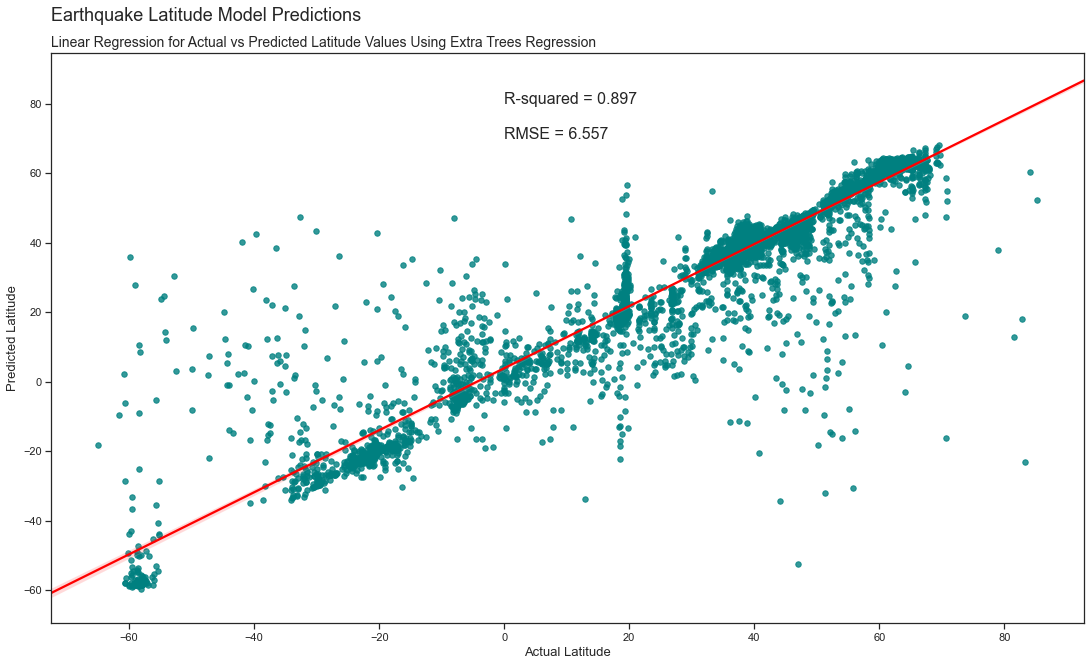

In [27]:
#plot actual vs predicted values
x = np.array(lat_pred_all['latitude'])
y = np.array(testpredict)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lat_pred_all['latitude'], testpredict)), (0, 80),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 70), fontsize=16)

fig.savefig('../static/images/extratrees_lat_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [28]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lon,depth,date_time_unix]]
y_pred = best_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: 14.98


Test with new data from USGS


In [29]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-05-13T04:12:28.810Z,37.504665,-118.836670,8.170000,1.96,md,19.0,121.0,0.085420,0.02,...,2022-05-13T04:14:06.378Z,"15km WSW of Toms Place, CA",earthquake,0.33,1.06,0.270,23.0,automatic,nc,nc
1,2022-05-13T04:04:41.470Z,19.136667,-155.412003,32.790001,1.85,md,35.0,178.0,NaN,0.10,...,2022-05-13T04:07:49.200Z,"10 km SE of Pāhala, Hawaii",earthquake,0.63,0.88,1.700,10.0,automatic,hv,hv
2,2022-05-13T04:03:55.130Z,60.251400,-152.789000,121.800000,1.60,ml,NaN,NaN,NaN,0.55,...,2022-05-13T04:11:45.231Z,"66 km WNW of Ninilchik, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
3,2022-05-13T04:02:17.421Z,60.772800,-150.378900,30.400000,1.20,ml,NaN,NaN,NaN,0.51,...,2022-05-13T04:05:04.023Z,"23 km SE of Point Possession, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
4,2022-05-13T04:01:27.240Z,33.674500,-116.765167,9.310000,0.18,ml,15.0,127.0,0.059430,0.12,...,2022-05-13T04:05:05.547Z,"8km SSW of Idyllwild, CA",earthquake,0.33,0.60,0.057,6.0,automatic,ci,ci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2022-05-12T04:42:26.775Z,63.399400,-151.338700,0.100000,1.60,ml,NaN,NaN,NaN,1.05,...,2022-05-12T04:47:31.928Z,"24 km SE of Denali National Park, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak
230,2022-05-12T04:28:58.326Z,60.236500,-140.761700,9.500000,0.80,ml,NaN,NaN,NaN,0.31,...,2022-05-12T18:50:32.333Z,"96 km NW of Yakutat, Alaska",earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
231,2022-05-12T04:28:12.860Z,38.828167,-122.814835,2.020000,1.33,md,26.0,42.0,0.006044,0.02,...,2022-05-12T07:54:11.070Z,"8km NW of The Geysers, CA",earthquake,0.19,0.34,0.360,2.0,automatic,nc,nc
232,2022-05-12T04:28:05.890Z,38.828335,-122.815170,1.960000,1.93,md,25.0,44.0,0.006339,0.02,...,2022-05-12T07:28:11.876Z,"8km NW of The Geysers, CA",earthquake,0.18,0.35,0.140,5.0,automatic,nc,nc


In [30]:
#create unix time column and drop columns not needed

test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix Time
0,37.504665,-118.836670,8.170000,1.96,1.652415e+09
1,19.136667,-155.412003,32.790001,1.85,1.652415e+09
2,60.251400,-152.789000,121.800000,1.60,1.652415e+09
3,60.772800,-150.378900,30.400000,1.20,1.652415e+09
4,33.674500,-116.765167,9.310000,0.18,1.652414e+09
...,...,...,...,...,...
229,63.399400,-151.338700,0.100000,1.60,1.652331e+09
230,60.236500,-140.761700,9.500000,0.80,1.652330e+09
231,38.828167,-122.814835,2.020000,1.33,1.652330e+09
232,38.828335,-122.815170,1.960000,1.93,1.652330e+09


In [31]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [32]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['latitude'], axis = 1)

y_test_data = cleaned_test_df[['latitude']]


In [33]:
#predict values with best model
pred_data_y = best_model.predict(X_test_data)


In [34]:
#create dataframe with values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,37.504665,-118.836670,8.170000,1.96,1.652415e+09,36.847472
1,19.136667,-155.412003,32.790001,1.85,1.652415e+09,19.205649
2,60.251400,-152.789000,121.800000,1.60,1.652415e+09,60.075631
3,60.772800,-150.378900,30.400000,1.20,1.652415e+09,62.375128
4,33.674500,-116.765167,9.310000,0.18,1.652414e+09,33.716857
...,...,...,...,...,...,...
229,63.399400,-151.338700,0.100000,1.60,1.652331e+09,63.522364
230,60.236500,-140.761700,9.500000,0.80,1.652330e+09,60.479895
231,38.828167,-122.814835,2.020000,1.33,1.652330e+09,38.826871
232,38.828335,-122.815170,1.960000,1.93,1.652330e+09,38.843735


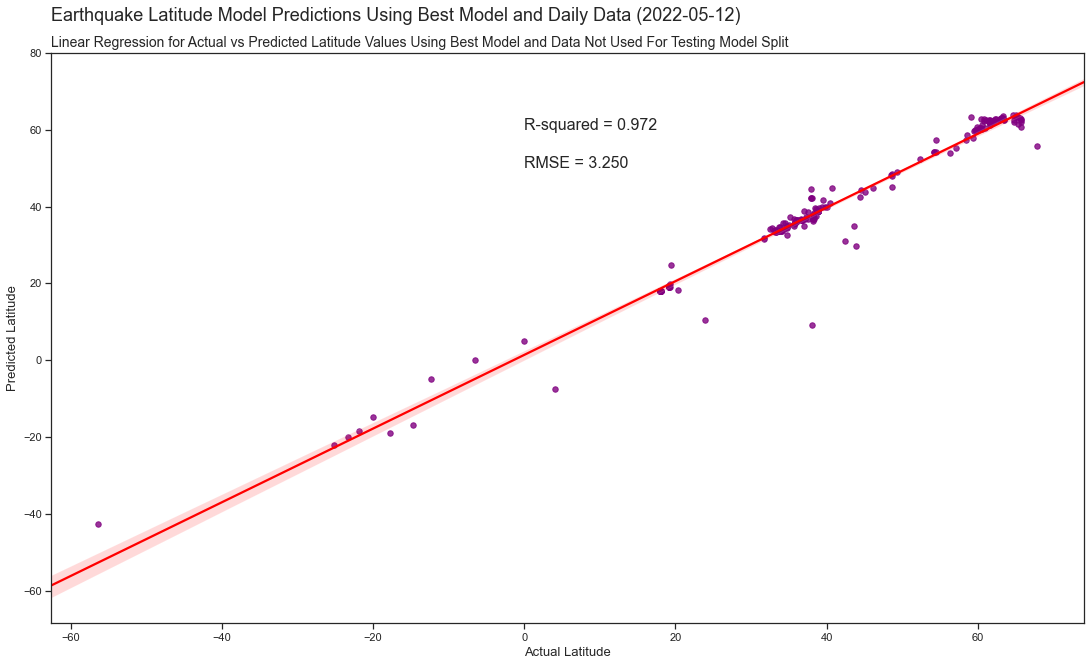

In [35]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()
x = np.array(test_pred_data['latitude'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Latitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 60),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 50), fontsize=16)

fig.savefig('../static/images/extratrees_lat_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [36]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")

Connected to database...


In [37]:
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lat_pred_all.to_sql('earthquake_etrees_lat', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lat_pred_all.to_sql('earthquake_etrees_lat', conn, if_exists='replace', index=False)

14815

In [38]:
# Close connection to SQLite database
conn.close()
connection.close()